In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pca import *
from manifold_scultpting import *

In [8]:
def generate_swiss_roll(n):

    x = np.zeros(n)
    y = np.zeros(n)
    z = np.zeros(n)

    for i in range(n):
        t = 8*i/n +2

        x[i]= t*np.sin(t)
        z[i]= t*np.cos(t)
        y[i]= np.random.uniform(-1, 1, 1)*6

    data = np.column_stack((x, y, z))

    return data

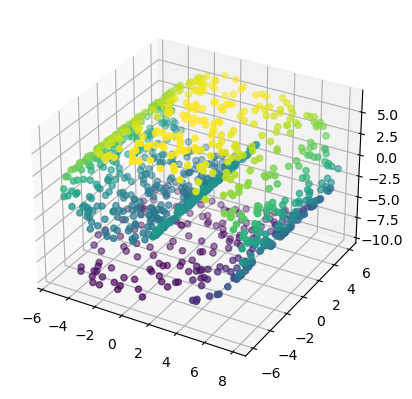

In [59]:
data = generate_swiss_roll(1000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c = data[:, 2])
plt.show()

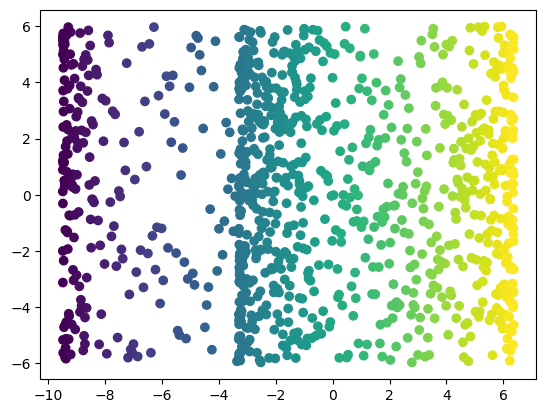

In [48]:
plt.scatter(data[:, 2], data[:, 1], c = data[:, 2])

In [47]:

idx, _ = pca_alg(data, 2)
idx

array([2, 1, 0], dtype=int64)

In [13]:
def get_local_relationships(data, k=10):
    
    dist = np.zeros((data.shape[0], k))
    neighbors = np.zeros((data.shape[0], k), dtype=int)

    # matrix of distances
    distances = np.zeros((data.shape[0], data.shape[0]))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            distances[i, j] = np.linalg.norm(data[i, :] - data[j, :])

    # keep track of average distance between each point and its neighbors
    avg_dist = 0

    # keep only the k nearest neighbors
    for i in range(data.shape[0]):
        neighbors[i, :] = np.argsort(distances[i, :])[1:k+1]
        dist[i, :] = np.sort(distances[i, :])[1:k+1]
        avg_dist += np.sum(dist[i, :]) / k

    avg_dist /= data.shape[0]

    # for each pair point neighbor (p,n) measure the angle between 
    # the segment p-n and n-m where m is the most colinear neighbor of n with p
    theta = np.zeros((data.shape[0], k)) #angles with colinear points
    colinear = np.zeros((data.shape[0], k), dtype=int) #indexes of colinear points

    for i in range(data.shape[0]):
        for j in range(k):
            n = int(neighbors[i, j])
            # find the most colinear neighbor of n with p
            # the most colinear neighbor is the one with the smallest angle
            # vector between p and n
            v1 = data[i,:] - data[n,:]

            # angles between p-n and n-m
            angles = np.zeros(data.shape[0])
            for z in range(k):
                m = int(neighbors[n, z])
                if m != i:
                    # vector between n and m
                    v2 = data[m,:] - data[n,:]
                    angles[m] = np.arccos(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            
            # choose the index of the angle which is neared to pi
            # because the angle between p-n and n-m is pi if the segment p-n is colinear with n-m
            colinear[i,j] = np.argmin(np.abs(angles - np.pi))
            theta[i,j] = angles[colinear[i,j]]

    return neighbors, dist, colinear, theta, avg_dist

In [60]:

def get_avg_dist(data, neighbors):

    avg_dist = 0
    k = neighbors.shape[1]
    for i in range(data.shape[0]):
        for j in range(k):
            avg_dist += np.linalg.norm(data[i,:] - data[neighbors[i,j],:])/k

    avg_dist /= data.shape[0]

    return avg_dist


def manifold_sculpting(data, k = 10, ndim=2, max_iter = 1000, th = 10**(-5)):
    """
    input:
        data: the dataset representing the manifold
        k: number of nearest neighbors to consider
        ndim: number of dimensions of the output space
        max_iter: maximum number of iterations
        th: threshold to stop the algorithm
    output:
        data transformed and projected in the 2D space
    """
    sigma = 0.9 # scaling factor

    # first step: find the k nearest neighbors for each point
    # second step: compute the distance between each point and its neighbors
    neighbors, dist0, colinear, angles0, avg_dist0 = get_local_relationships(data, k) # matrix of distances with only the k nearest neighbors

    eta = copy.deepcopy(avg_dist0)
    #eta = 0.2
    # third step: find principal directions through PCA
    # and align the data along the principal directions (not done for the moment)
    #idx, _ = pca_alg(data, 2)

    #dpres = idx[:ndim]  # dimensions to be preserved
    #dscal = idx[ndim:] # dimensions to be discarded

    #pca = PCA(n_components=3)
    #pca.fit(data)
    #x_pca = pca.transform(data)

    _, U = pca_alg(data, 3) # keep all dimensions to see just the rotation
    x_pca = copy.deepcopy(data)# np.dot(X, U)

    dpres = [0,1]
    dscal = [2]

    prev_data = copy.deepcopy(x_pca)
    # fourth step: iteratively transform data until stop criterion is met
    # stop when all sum of changes for all the points is less than a threshold
    # or if the maximum number of iterations is reached

    for i in tqdm(range(max_iter)):

        # 4a: scale the data along the discarded dimensions
        for j in range(x_pca.shape[0]):
            x_pca[j, dscal] *= sigma

        # The values in Dpres are scaled up to keep 
        # the average neighbor distance equal to avg_dist
        while get_avg_dist(x_pca, neighbors) < avg_dist0:
            for j in range(x_pca.shape[0]):
                x_pca[j, dpres] /= sigma

        
        # create queue of points 
        q = queue.Queue()

        # add a random point to the queue
        curr_idx = np.random.randint(0, x_pca.shape[0], 1).item()
        q.put(curr_idx)

        # keep list of adjusted points
        adj_data = []

        step = 0 

        # while queue is not empty
        while not q.empty():
            # pick point from queue
            curr_idx = q.get()
            
            if curr_idx not in adj_data: # if current point has not been adjusted jet
                s, x_pca = adjust_points(x_pca, curr_idx, eta, avg_dist0, dpres, neighbors, dist0, colinear, angles0, adj_data)
                
                step += s
                # add current point to adjusted points
                adj_data.append(curr_idx)

                # add neighbors to queue
                for n in neighbors[curr_idx, :]:
                    q.put(int(n))


        if step >= x_pca.shape[0]:
            eta /= 0.9
        else:
            eta *= 0.9

        # stop criterion
        # if data has not changed much, stop
        change = np.sum(np.abs(x_pca - prev_data))
        prev_data = copy.deepcopy(x_pca)

        if change < th:
            print("Converged after {} iterations".format(i))
            break
        
        if i % 30 == 0:
            print("Iteration: {}, change: {}".format(i, change))

    # final step: project points by dropping the discarded dimensions
    return x_pca#[:, dpres]



def compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data):
    c = 10
    error = 0
    # heuristic error value is used to evaluate the current relationships
    # among data points relative to the original relationships

    for i,j in enumerate(neighbors[curr_idx, :]):
        # weight of the error
        w = 1 
        # change weight if point j has already been adjusted
        if j in adj_data:
            w = c
        
        # distance between current point and point j
        new_dist = np.linalg.norm(data[curr_idx, :] - data[j, :])
        v1 = data[curr_idx, :] - data[j, :] # dist between curr point and point j
        v2 = data[colinear[curr_idx,i], :] - data[j, :] # dist between colinear point with current one through point j and point j

        #new_angle = np.arccos(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))) if (np.linalg.norm(v1) * np.linalg.norm(v2)) != 0 else 0

        try:
            if (np.linalg.norm(v1) * np.linalg.norm(v2)) == 0:
                new_angle = 0
            else:
                new_angle = np.arccos(np.clip(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1,1))
        except:
            print('v1: ', v1)
            print('v2: ', v2)
            print('np.linalg.norm(v1): ', np.linalg.norm(v1))
            print('np.linalg.norm(v2): ', np.linalg.norm(v2))
            print('np.dot(v1,v2): ', np.dot(v1,v2))

        error_dist = (( dist0[curr_idx, i] - new_dist)/(2*avg_dist))**2 
        error_angle  = ((angles0[curr_idx, i] - new_angle)/np.pi)**2
        
        error += w *( error_dist + error_angle )

    return error



def adjust_points(data, curr_idx, eta, avg_dist, dpres, neighbors, dist0, colinear, angles0, adj_data):
    s = 0
    improved = True

    eta = 0.2*eta
    #print('prev_point: ', data[curr_idx, :])
    while improved: # until we are in a local minimum
        s += 1
        improved = False

        error = compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data)

        #print('error: ', error)
        for d in dpres:
            data[curr_idx, d] += eta
            #print('up point: ', data[curr_idx, :])
            
            new_error = compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data)
            # empirically moving along one of the direction to be preserved
            # choosing the versus by evaluating how the error changes moving both up and down
            if new_error > error:
                #print('new_error ', new_error)
                data[curr_idx, d] -= 2*eta
                #print('down point: ', data[curr_idx, :])
                
                new_error = compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data)
                if  new_error > error:
                    #print('new_error ', new_error)
                    data[curr_idx, d] += eta
                    #print('up point: ', data[curr_idx, :])
                else:
                    improved = True
            else:
                improved = True
    #print('post_point: ', data[curr_idx, :])

    return s, data


In [61]:
ds = copy.deepcopy(data)
# call function to get the desired relationships
neighbors, dist, colinear, theta, avg_dist = get_local_relationships(ds, k=10)

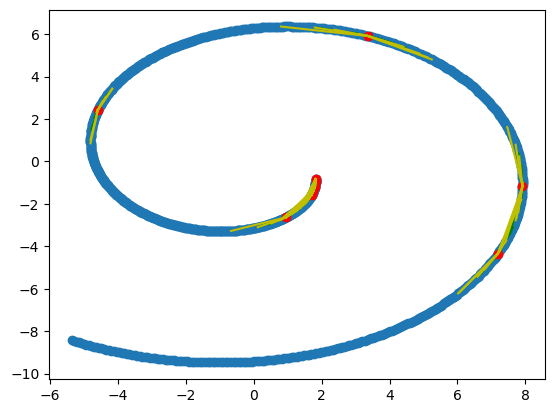

In [62]:
# choose one point and plot relationships
p = [8,0, 20 ,30, 40,100,400,600, 750, 800]
plt.scatter(ds[:,0], ds[:,2])
for point in p:
    plt.scatter(ds[point,0], ds[point,2], c='r')

for point in p:
    for i in range(10):
        j = int(neighbors[point, i])
        plt.plot([ds[point,0], ds[j,0]], [ds[point,2], ds[j,2]], c='g')


# plot the most colinear neighbor of each neighbor of the chosen point

for point in p:
    for i,idx in enumerate(colinear[point,:]):
        plt.plot([ds[point,0], ds[int(idx),0]], [ds[point,2], ds[int(idx), 2]], c='y')


plt.show()

In [63]:
ds = copy.deepcopy(data)
d = manifold_sculpting(ds, k = 10, max_iter = 50, th = 10**(-20))

  2%|▏         | 1/50 [00:09<07:57,  9.74s/it]

Iteration: 0, change: 1187.4807677746644


 62%|██████▏   | 31/50 [04:17<01:19,  4.17s/it]

Iteration: 30, change: 173.05816599098532


100%|██████████| 50/50 [05:26<00:00,  6.53s/it]


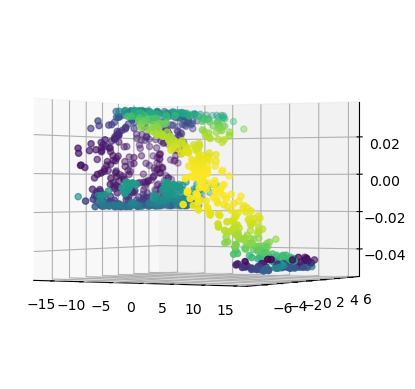

In [67]:
# this after 100 iterations
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d[:,0], d[:,1], d[:,2], c=data[:,0], cmap='viridis')

# change the angle of the axes
ax.view_init(0, -60)

plt.show()

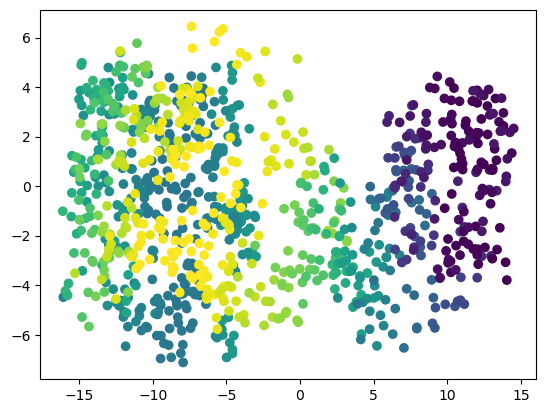

In [66]:

plt.scatter(d[:,0], d[:,1], c=d[:,2], cmap='viridis')


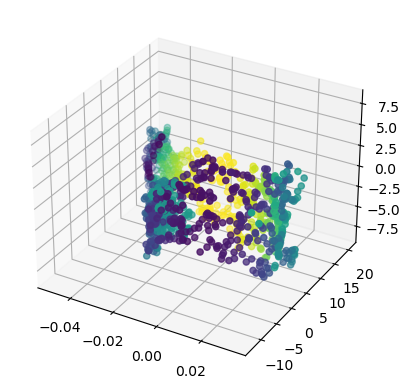

In [57]:
# this after 50 iterations
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d[:,0], d[:,1], d[:,2], c=data[:,0], cmap='viridis')

# change the angle of the axes
#ax.view_init(10, -60)

plt.show()

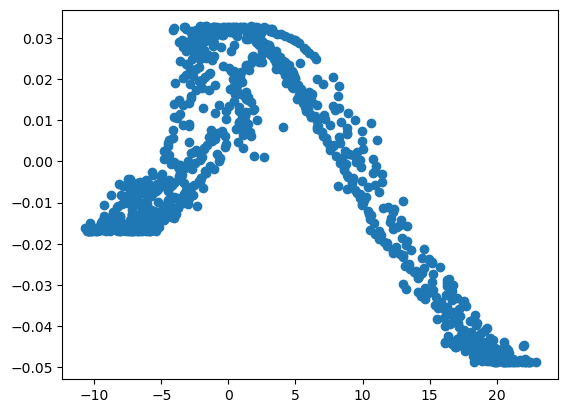

In [30]:
plt.scatter(d[:,0], d[:,2])
